In [1]:
import sys
import os
import numpy as np
import json

from sklearn.model_selection import train_test_split
import pandas as pd

import tensorflow as tf
import keras.backend.tensorflow_backend as K
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential

from keras.optimizers import SGD

from keras.layers import Bidirectional
from keras.layers import Dense, Conv1D, Embedding, Activation, LSTM, CuDNNLSTM
from keras.layers import Dropout, MaxPooling1D, GlobalMaxPool1D

from keras import regularizers 
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
import re
import json
from eunjeon import Mecab
from tqdm import tqdm_notebook

from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

In [3]:
tf.set_random_seed(201)
np.random.seed(201)

In [4]:
df_union = pd.read_csv('./data/dc_db.csv', sep=',', encoding='utf-8', index_col=0)
df_union.head()

from konlpy.tag import Okt
okt = Okt()

stop_words = set(['은', '는', '이', '가', '하', '아', '것',
                  '들', '의', '있', '되', '수', '보', '주',
                  '등', '한'])

docs = []

C:\Users\VI\Anaconda3\envs\badWord\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [5]:
def tokenize(doc):
    #return ['/'.join(t) for t in mecab.pos(doc)]
    return ['/'.join(t) for t in okt.pos(doc)]

In [6]:
def pos_preprocessing(data, okt, remove_stopwords=False, stop_words=[]):
    data_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", data)
    #words = mecab.morphs(data_text)
    words = tokenize(data_text)
    if remove_stopwords:
        words = [token for token in words]

    return words

## 테스트 데이터 입력 

In [7]:
test_str = '안녕하세요'

In [8]:
df_test = pd.Series(['test_input', test_str, ''], index=['gall_name', 'cmt_contents', 'label'])
df = df_union.append(df_test, ignore_index=True)
df.tail()

,gall_name,cmt_contents,label
9284,history,말로만 가고싶다고 하지말고 직접한번 가봐라 병신들 - dc App,1
9285,history,"단순한 생각의 실험은 아닌 것 같고, 만약 창작의 소재라면... 패망 당시, 국본...",0
9286,history,음.. 예를 들자면 GHQ와 新 공화국 정부가 군부 잔존 세력 및 왕당파 세력의 ...,0
9287,history,"몰랐는데, 한 사람이 장기간 도배 했네. 대단함. 병신력이든, 잉여력이든, 했다...",1
9288,test_input,안녕하세요,


In [9]:
for review in tqdm_notebook(df['cmt_contents']):
    if type(review) == str:
        docs.append(pos_preprocessing(review, okt, remove_stopwords=False,
                                                stop_words=stop_words))
    else:
        docs.append([])

C:\Users\VI\Anaconda3\envs\badWord\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(docs)
test_sequences = tokenizer.texts_to_sequences(docs)
word_vocab = tokenizer.word_index

MAX_SEQUENCE_LENGTH = 12

test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
train_labels = np.array(df['label'])

data_configs = {}

In [11]:
input_data = test_inputs[:-1]
label_data = train_labels[:-1]
print(input_data.shape)
print(label_data.shape)

(9288, 12)
(9288,)


In [12]:
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

## 데이터 로드

In [13]:
TEST_SPLIT = 0.2
RND_SEED = 0
VOCAB_SIZE = data_configs['vocab_size']+1
EMB_SIZE = 128
BATCH_SIZE = 512
MAX_LEN = 200
max_features = 20000

In [14]:
train_input, eval_input, train_label, eval_label = train_test_split(input_data,
                                                                    label_data,
                                                                    test_size=TEST_SPLIT,
                                                                    random_state=RND_SEED)

In [15]:
train_input = sequence.pad_sequences(train_input, maxlen=MAX_LEN)
eval_input = sequence.pad_sequences(eval_input, maxlen=MAX_LEN)

## 모델 설정

In [16]:
def Model():
    model = Sequential()
    model.add(Embedding(max_features, EMB_SIZE, input_length=MAX_LEN))    
    model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [17]:
model = Model()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 128)          99328     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,667,649
Tr

In [18]:
# 최선의 모델 model 저장
MODEL_PATH = './model/'
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

model_full_path = MODEL_PATH + 'best_train_model.hdf5'

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min')
check_point = ModelCheckpoint(filepath=model_full_path, monitor='val_loss', verbose=0, save_best_only=True)

In [20]:
with K.tf_ops.device('/device:GPU:0'):
    hist = model.fit(train_input, train_label, batch_size = BATCH_SIZE,
                     epochs = 10, validation_split = 0.2, callbacks=[early_stopping, check_point])


Train on 5944 samples, validate on 1486 samples
Epoch 1/10
5944/5944 [==============================] - ETA: 20s - loss: 0.7017 - accuracy: 0.224 - ETA: 9s - loss: 0.6953 - accuracy: 0.494 - ETA: 3s - loss: 0.6840 - accuracy: 0.63 - ETA: 2s - loss: 0.6717 - accuracy: 0.68 - ETA: 1s - loss: 0.6655 - accuracy: 0.69 - ETA: 0s - loss: 0.6519 - accuracy: 0.70 - ETA: 0s - loss: 0.6426 - accuracy: 0.71 - 3s 425us/step - loss: 0.6296 - accuracy: 0.7211 - val_loss: 0.5259 - val_accuracy: 0.7833
Epoch 2/10
5944/5944 [==============================] - ETA: 0s - loss: 0.5160 - accuracy: 0.78 - ETA: 0s - loss: 0.5286 - accuracy: 0.78 - ETA: 0s - loss: 0.5375 - accuracy: 0.78 - ETA: 0s - loss: 0.5515 - accuracy: 0.77 - ETA: 0s - loss: 0.5478 - accuracy: 0.77 - ETA: 0s - loss: 0.5444 - accuracy: 0.77 - 0s 79us/step - loss: 0.5458 - accuracy: 0.7710 - val_loss: 0.5321 - val_accuracy: 0.7833


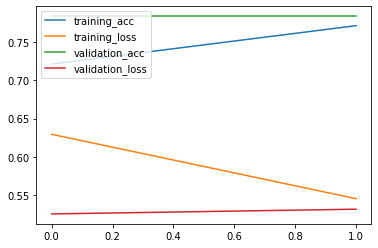

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['val_loss'])
plt.legend(['training_acc', 'training_loss','validation_acc', 'validation_loss'], loc = 'upper left')
plt.show()

In [22]:
model.load_weights(model_full_path)
results = model.evaluate(eval_input, eval_label)

1858/1858 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 515us/step


In [23]:
print('Test accuracy: ', results[1])

Test accuracy:  0.7814854979515076


## K-fold validation 사용 

In [24]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=20, random_state=RND_SEED, shuffle=True)

for train_index, test_index in kf.split(input_data):
    X_train, X_test = input_data[train_index], input_data[test_index]
    y_train, y_test = label_data[train_index], label_data[test_index]
    
X_train = sequence.pad_sequences(X_train, maxlen=MAX_LEN)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_LEN)

In [25]:
model = Model()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 128)          99328     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 2,667,649
Trainable params: 2,667,649
Non-trainable params: 0
____________________________________________

In [26]:
with K.tf_ops.device('/device:GPU:0'):
    hist = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = 5)

Epoch 1/5
8824/8824 [==============================] - ETA: 6s - loss: 0.7014 - accuracy: 0.19 - ETA: 2s - loss: 0.6857 - accuracy: 0.58 - ETA: 1s - loss: 0.6788 - accuracy: 0.63 - ETA: 1s - loss: 0.6647 - accuracy: 0.67 - ETA: 0s - loss: 0.6497 - accuracy: 0.69 - ETA: 0s - loss: 0.6293 - accuracy: 0.71 - ETA: 0s - loss: 0.6193 - accuracy: 0.71 - ETA: 0s - loss: 0.6087 - accuracy: 0.72 - ETA: 0s - loss: 0.6015 - accuracy: 0.73 - ETA: 0s - loss: 0.5963 - accuracy: 0.73 - 1s 119us/step - loss: 0.5959 - accuracy: 0.7375
Epoch 2/5
8824/8824 [==============================] - ETA: 0s - loss: 0.5500 - accuracy: 0.76 - ETA: 0s - loss: 0.5339 - accuracy: 0.77 - ETA: 0s - loss: 0.5369 - accuracy: 0.77 - ETA: 0s - loss: 0.5369 - accuracy: 0.77 - ETA: 0s - loss: 0.5372 - accuracy: 0.77 - ETA: 0s - loss: 0.5363 - accuracy: 0.77 - ETA: 0s - loss: 0.5380 - accuracy: 0.77 - ETA: 0s - loss: 0.5402 - accuracy: 0.77 - ETA: 0s - loss: 0.5375 - accuracy: 0.77 - ETA: 0s - loss: 0.5362 - accuracy: 0.77 - 1s

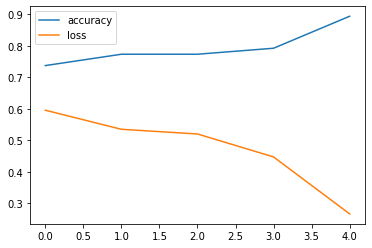

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.legend(['accuracy', 'loss'], loc = 'upper left')
plt.show()

In [28]:
score = model.evaluate(X_test,y_test)

464/464 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 758us/step


In [29]:
print('Test accuracy: ', score[1])

Test accuracy:  0.8879310488700867


## 테스트

In [30]:
test = sequence.pad_sequences(test_inputs, maxlen=MAX_LEN)
test_in = np.reshape(test[-1], [-1, 200])
test_in

model.predict_classes(test_in)

array([[0]])